In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

import json
import pandas as pd
data =pd.read_json("./sarcasm.json")
data.head()

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 291MB/s]


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Préprocessing NLP (remove URLs, lowercase, stopwords, lemmatisation)

In [ ]:
# preprocess_nlp.py
import re
import json
import pandas as pd
import os  # Added for path handling
from google.colab import drive # Added to ensure drive access

# Option 1: spaCy (préféré pour la lemmatisation)
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    SPACY_OK = True
except Exception:
    SPACY_OK = False
    print("spaCy 'en_core_web_sm' introuvable — essayer d'installer via: python -m spacy download en_core_web_sm")
    # fallback minimal lemmatizer
    from nltk.stem import WordNetLemmatizer
    import nltk
    nltk.download("wordnet")
    nltk.download("omw-1.4")
    lemmatizer = WordNetLemmatizer()
    from nltk.corpus import stopwords
    nltk.download("stopwords")
    EN_STOPWORDS = set(stopwords.words("english"))

# Fonction de nettoyage (supprime urls, ponctuation basique, met en lowercase)
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # supprimer urls
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # enlever caractères non alphanum (garder apostrophes)
    text = re.sub(r"[^\w\s']", " ", text)
    text = text.lower()
    # normaliser espaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_and_remove_stopwords(text):
    text = clean_text(text)
    if SPACY_OK:
        doc = nlp(text)
        tokens = [tok.lemma_ for tok in doc if not tok.is_stop and tok.lemma_.strip()]
        return " ".join(tokens)
    else:
        # fallback basique avec NLTK lemmatizer + stopwords
        tokens = text.split()
        filtered = [lemmatizer.lemmatize(t) for t in tokens if t not in EN_STOPWORDS]
        return " ".join(filtered)

# --- Charger sarcasm.json ---
# Assurez-vous que le fichier sarcasm.json est bien uploadé dans l'environnement Colab ou Drive
data_path = "./sarcasm.json"

# Gestion d'erreur si le fichier n'est pas trouvé à la racine
if not os.path.exists(data_path):
    print(f"ATTENTION: '{data_path}' introuvable. Vérifiez le chemin d'entrée.")
    # Exemple si le json est aussi dans le dossier Lab Sarcasm:
    # data_path = "/content/drive/MyDrive/Lab Sarcasm/sarcasm.json"

try:
    df = pd.read_json(data_path, lines=True)
except ValueError:
    df = pd.read_json(data_path)

# Déterminer la colonne texte et label
text_col = None
for c in ['headline', 'text', 'body', 'comment', 'sentence']:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    candidate_cols = [c for c in df.columns if c not in ('is_sarcastic','label','target','article_link','url')]
    text_col = candidate_cols[0]

label_col = None
for c in ['is_sarcastic', 'label', 'target']:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    for c in df.columns:
        if set(df[c].dropna().unique()).issubset({0,1}):
            label_col = c
            break

print("Text column:", text_col)
print("Label column:", label_col)

# Appliquer nettoyage + lemmatisation
df['clean'] = df[text_col].astype(str).apply(clean_text)
df['clean_nolemma'] = df['clean']
df['clean'] = df['clean'].apply(lemmatize_and_remove_stopwords)

# Supprimer colonne URL/link si présente
for col in ['article_link', 'link', 'url']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Garder seulement texte nettoyé et labels
if label_col is None:
    raise ValueError("Impossible de détecter la colonne label (is_sarcastic / label / target). Vérifie le JSON.")
df = df[[ 'clean', label_col ]].rename(columns={label_col: 'label'})

# Vérification
print(df.head())
print("Nombre exemples:", len(df))

# --- SAUVEGARDE DANS GOOGLE DRIVE ---

# 1. Monter le Drive (nécessaire si ce n'est pas déjà fait)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Définir le dossier de sortie
output_dir = "/content/drive/MyDrive/Lab_Sarcasm"

# 3. Créer le dossier s'il n'existe pas encore
os.makedirs(output_dir, exist_ok=True)

# 4. Chemin complet du fichier
output_path = os.path.join(output_dir, "sarcasm_clean.csv")

# 5. Sauvegarder
df.to_csv(output_path, index=False)
print(f"Fichier sauvegardé avec succès vers : {output_path}")

Text column: headline
Label column: is_sarcastic
                                               clean  label
0  versace store clerk sue secret ' black code ' ...      0
1  ' roseanne ' revival catch thorny political mo...      0
2  mom start fear son web series close thing gran...      1
3  boehner want wife listen come alternative debt...      1
4  j k rowling wish snape happy birthday magical way      0
Nombre exemples: 26709
Fichier sauvegardé avec succès vers : /content/drive/MyDrive/Lab_Sarcasm/sarcasm_clean.csv


In [ ]:
import pandas as pd
import os

# Define the path clearly so it's easy to change if needed
drive_folder = "/content/drive/MyDrive/Lab_Sarcasm"
file_path = os.path.join(drive_folder, "sarcasm_clean.csv")

# Load the data using the drive path
# (Make sure Drive is mounted: from google.colab import drive; drive.mount('/content/drive'))
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the directory name (Lab_Sarcasm vs Lab Sarcasm).")
    # Fallback to local if needed
    df = pd.read_csv("sarcasm_clean.csv")

# Function to remove apostrophes
def remove_apostrophes(text):
    if isinstance(text, str):
        return text.replace("'", "")
    return text

# Apply the function to the 'clean' column
df['clean'] = df['clean'].apply(remove_apostrophes)

# Display head to confirm
print("DataFrame after removing apostrophes:")
print(df.head())

# --- SAVE TO DRIVE ---
# We use the same path variable to save it back to the folder
output_path = os.path.join(drive_folder, "sarcasm_clean.csv")

df.to_csv(output_path, index=False)
print(f"Updated file saved to: {output_path}")

Successfully loaded data from /content/drive/MyDrive/Lab_Sarcasm/sarcasm_clean.csv
DataFrame after removing apostrophes:
                                               clean  label
0  versace store clerk sue secret  black code  mi...      0
1   roseanne  revival catch thorny political mood...      0
2  mom start fear son web series close thing gran...      1
3  boehner want wife listen come alternative debt...      1
4  j k rowling wish snape happy birthday magical way      0
Updated file saved to: /content/drive/MyDrive/Lab_Sarcasm/sarcasm_clean.csv


In [ ]:
df['label'].value_counts()

,count
label,
0,14985
1,11724


## Tokenization + padding + split

In [ ]:
# tokenize_and_pad.py
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle

# Charger le CSV nettoyé produit par le snippet précédent
df = pd.read_csv("/content/drive/MyDrive/Lab_Sarcasm/sarcasm_clean.csv")
texts = df['clean'].astype(str).tolist()
labels = df['label'].astype(int).tolist()  # 0 ou 1

# Hyperparams tokenizer / padding
vocab_size = 10000
oov_token = "<OOV>"
max_len = 40   # longueur de séquence fixe (adapter si besoin)
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)

# Convert to sequences + pad
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    padded, labels, test_size=0.2, random_state=42, stratify=labels
)

# Sauvegarder tokenizer et données numpy
with open("tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)
np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

print("Tokenization terminée.")
print("Vocab size (tokenizer.word_index):", len(tokenizer.word_index))
print("Shapes:", X_train.shape, X_test.shape)


Tokenization terminée.
Vocab size (tokenizer.word_index): 19903
Shapes: (21367, 40) (5342, 40)


In [ ]:
word_index =tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'trump': 2, 'new': 3, 'man': 4, 'woman': 5, 'year': 6, 'report': 7, 'day': 8, 'say': 9, 'area': 10, 'time': 11, 'get': 12, 'donald': 13, 'u': 14, 'find': 15, 'good': 16, 'old': 17, 's': 18, 'like': 19, 'life': 20, 'obama': 21, 'people': 22, 'way': 23, 'world': 24, 'nation': 25, 'go': 26, 'house': 27, 'thing': 28, 'look': 29, 'clinton': 30, 'white': 31, 'want': 32, 'child': 33, 'know': 34, 'family': 35, 'watch': 36, 'come': 37, 'work': 38, 'think': 39, 'school': 40, '5': 41, 'take': 42, 'love': 43, 'need': 44, 'right': 45, 'plan': 46, 'make': 47, 'state': 48, 'tell': 49, 'black': 50, 'change': 51, 'mom': 52, 'big': 53, 'americans': 54, 'gop': 55, 'study': 56, 'american': 57, 'kid': 58, 'star': 59, 'bill': 60, 'kill': 61, 'call': 62, 'president': 63, '3': 64, 'home': 65, 'death': 66, 'parent': 67, 'america': 68, 'police': 69, 'friend': 70, 'talk': 71, 'help': 72, 'video': 73, 'ask': 74, 'leave': 75, 'live': 76, '10': 77, 'bad': 78, 'win': 79, 'give': 80, 'try': 81, 'student'

## ANN classifier training (Model No embeddings)

## Training

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# --- 1. SETUP PATHS ---
# Try to detect the correct folder name (with underscore or space)
base_path = "/content/drive/MyDrive/Lab_Sarcasm"
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

print(f"Working in directory: {base_path}")

# --- 2. LOAD & PROCESS DATA ---
csv_path = os.path.join(base_path, "sarcasm_clean.csv")
print(f"Loading data from {csv_path}...")
df = pd.read_csv(csv_path)

# Ensure text column is string
df['clean'] = df['clean'].astype(str)

# Parameters
vocab_size = 10000
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Initialize and Fit Tokenizer
print("Creating and saving tokenizer...")
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df['clean'])

# SAVE TOKENIZER (This fixes your error)
with open(os.path.join(base_path, "tokenizer.pickle"), "wb") as f:
    pickle.dump(tokenizer, f)

# Convert to sequences
sequences = tokenizer.texts_to_sequences(df['clean'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Split Data
X = np.array(padded)
y = np.array(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the numpy arrays so you can reload them faster next time if needed
np.save(os.path.join(base_path, "X_train.npy"), X_train)
np.save(os.path.join(base_path, "X_test.npy"), X_test)
np.save(os.path.join(base_path, "y_train.npy"), y_train)
np.save(os.path.join(base_path, "y_test.npy"), y_test)

# --- 3. BUILD MODEL ---
print("Building model...")
model = Sequential([
    # Input shape matches max_length
    Flatten(input_shape=(max_length,)),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-4))
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- 4. TRAIN MODEL ---
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("class_weights =", class_weights_dict)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=64,
    callbacks=[es],
    class_weight=class_weights_dict,
    verbose=2
)

# --- 5. SAVE MODEL ---
model_save_path = os.path.join(base_path, "sarcasm_no_embedding_model.h5")
model.save(model_save_path)
print(f"Model saved successfully to: {model_save_path}")

Working in directory: /content/drive/MyDrive/Lab_Sarcasm
Loading data from /content/drive/MyDrive/Lab_Sarcasm/sarcasm_clean.csv...
Creating and saving tokenizer...
Building model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

class_weights = {0: np.float64(0.8911085161397948), 1: np.float64(1.1392087865216465)}
Epoch 1/50
301/301 - 6s - 20ms/step - accuracy: 0.4908 - loss: 287.5773 - val_accuracy: 0.4881 - val_loss: 128.8590
Epoch 2/50
301/301 - 1s - 3ms/step - accuracy: 0.5022 - loss: 212.2234 - val_accuracy: 0.5194 - val_loss: 82.3885
Epoch 3/50
301/301 - 1s - 2ms/step - accuracy: 0.4998 - loss: 173.0775 - val_accuracy: 0.5194 - val_loss: 63.5416
Epoch 4/50
301/301 - 1s - 3ms/step - accuracy: 0.5015 - loss: 140.7168 - val_accuracy: 0.5339 - val_loss: 51.7129
Epoch 5/50
301/301 - 1s - 2ms/step - accuracy: 0.4993 - loss: 116.5758 - val_accuracy: 0.5297 - val_loss: 45.2059
Epoch 6/50
301/301 - 1s - 3ms/step - accuracy: 0.5033 - loss: 95.8822 - val_accuracy: 0.5166 - val_loss: 37.8378
Epoch 7/50
301/301 - 1s - 4ms/step - accuracy: 0.5092 - loss: 76.5570 - val_accuracy: 0.5133 - val_loss: 32.3373
Epoch 8/50
301/301 - 1s - 3ms/step - accuracy: 0.5088 - loss: 63.8327 - val_accuracy: 0.5152 - val_loss: 27.3207
Ep

Model saved successfully to: /content/drive/MyDrive/Lab_Sarcasm/sarcasm_no_embedding_model.h5


## Evaluation

In [ ]:
# evaluate_on_test_set.py
import numpy as np
import pickle
import os
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# --- PATH CONFIGURATION ---
base_path = "/content/drive/MyDrive/Lab_Sarcasm"

# Define filenames
model_filename = "sarcasm_no_embedding_model.h5"
tokenizer_filename = "tokenizer.pickle"

# Full paths
model_path = os.path.join(base_path, model_filename)
tokenizer_path = os.path.join(base_path, tokenizer_filename)

# --- LOAD RESOURCES ---
print(f"Loading model from: {model_path}")
model = load_model(model_path)

print(f"Loading tokenizer from: {tokenizer_path}")
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# --- LOAD TEST DATA ---
print("Loading test data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

# --- EVALUATE ---
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🔥 Test Loss  : {loss:.4f}")
print(f"🔥 Test Acc   : {acc*100:.2f}%\n")

# --- DETAILED METRICS ---
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# 1. Print to Console (for quick view)
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# --- SAVE EVALUATION TO CSV ---

# Generate report as a dictionary to convert to DataFrame
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Add Confusion Matrix data to the DataFrame (optional but useful)
# We can add it as a separate row or just print it,
# but usually, the classification report is what people want in the CSV.
# Let's simple add the accuracy and loss to the dataframe metadata or name
df_report.loc['accuracy_score'] = [acc, acc, acc, len(y_test)]

# Construct CSV filename based on model name
# Removes '.h5' and adds '_evaluation.csv'
csv_filename = model_filename.replace('.h5', '') + "_evaluation.csv"
csv_path = os.path.join(base_path, csv_filename)

df_report.to_csv(csv_path)

print("-" * 30)
print(f"✅ Evaluation saved to: {csv_path}")

Loading model from: /content/drive/MyDrive/Lab_Sarcasm/sarcasm_no_embedding_model.h5


Loading tokenizer from: /content/drive/MyDrive/Lab_Sarcasm/tokenizer.pickle
Loading test data...

🔥 Test Loss  : 0.7099
🔥 Test Acc   : 56.81%

Classification Report:
              precision    recall  f1-score   support

           0     0.5998    0.6913    0.6423      2996
           1     0.5103    0.4109    0.4553      2346

    accuracy                         0.5681      5342
   macro avg     0.5550    0.5511    0.5488      5342
weighted avg     0.5605    0.5681    0.5601      5342

Confusion Matrix:
[[2071  925]
 [1382  964]]
------------------------------
✅ Evaluation saved to: /content/drive/MyDrive/Lab_Sarcasm/sarcasm_no_embedding_model_evaluation.csv


✅ Working directory detected: /content/drive/MyDrive/Lab_Sarcasm
Loading model from /content/drive/MyDrive/Lab_Sarcasm/sarcasm_no_embedding_model.h5...
Loading test data...
Predicting...
AUC = 0.5713


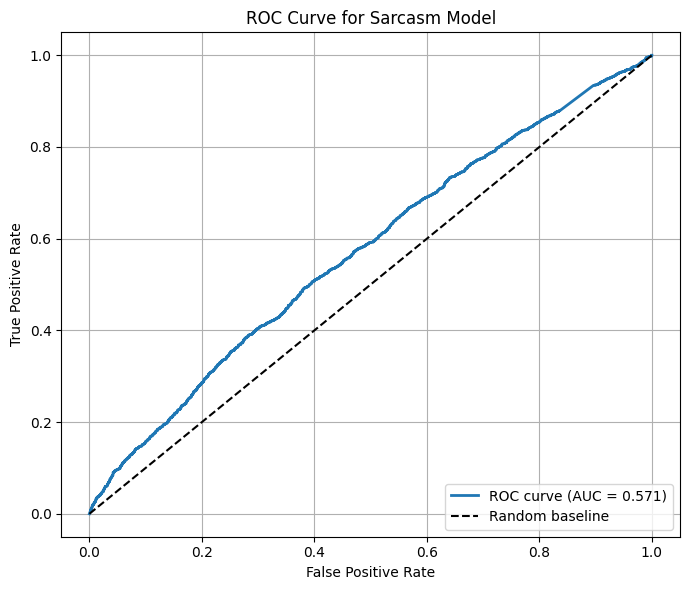

✅ ROC curve saved as: /content/drive/MyDrive/Lab_Sarcasm/roc_curve_existing_model.png


In [ ]:
# roc_auc_existing_model.py
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os

# --- PATH CONFIGURATION (Auto-Detect) ---
# We check both possibilities to prevent FileNotFoundError
base_path = "/content/drive/MyDrive/Lab_Sarcasm"
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

print(f"✅ Working directory detected: {base_path}")

# --- Load trained model ---
model_path = os.path.join(base_path, "sarcasm_no_embedding_model.h5")
print(f"Loading model from {model_path}...")
model = load_model(model_path)

# --- Load test data ---
# We add a check here to ensure files exist before crashing
x_path = os.path.join(base_path, "X_test.npy")
y_path = os.path.join(base_path, "y_test.npy")

if not os.path.exists(y_path):
    print(f"❌ ERROR: Could not find 'y_test.npy' at {y_path}")
    print("👉 Solution: Please re-run the 'preprocess_nlp.py' or training script to generate the .npy files.")
    raise FileNotFoundError("Stopping execution because data is missing.")

print("Loading test data...")
X_test = np.load(x_path)
y_test = np.load(y_path)

# --- Predict probabilities ---
print("Predicting...")
y_prob = model.predict(X_test, verbose=0).ravel()

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC = {roc_auc:.4f}")

# --- Plot ---
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Sarcasm Model") # Cleaned up title
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()

# Save plot to drive
plot_path = os.path.join(base_path, "roc_curve_existing_model.png")
plt.savefig(plot_path)
plt.show()

print(f"✅ ROC curve saved as: {plot_path}")

## Testing

In [ ]:
# test_on_custom_20.py
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

model = load_model("/content/drive/MyDrive/Lab_Sarcasm/sarcasm_no_embedding_model.h5")

with open("tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

max_len = X_test.shape[1]

sentences = [
    # Sarcastic (1)
    "Oh yes, because waking up at 5am is exactly what I wanted.",
    "Amazing, another update that totally broke my phone.",
    "Great job! You only crashed the car a little bit.",
    "Wow, I love when my food delivery arrives two hours late.",
    "Fantastic, now my computer won’t even turn on.",
    "Perfect! It started raining right after I washed my car.",
    "Sure, let’s pretend everything is totally fine.",
    "Oh wonderful, the meeting got extended by an hour.",
    "Yeah, because that was the smartest idea ever.",
    "Lovely, the bus left just as I arrived.",
    # Non-sarcastic (0)
    "I enjoyed spending time with my family today.",
    "The movie was very good, I would recommend it.",
    "I had a terrible headache this morning.",
    "He finally finished his project after months of work.",
    "The weather is nice and sunny this afternoon.",
    "I am really happy with my new phone.",
    "My dog got sick, and I had to take him to the vet.",
    "I’m studying hard because exams are next week.",
    "The concert last night was absolutely amazing.",
    "I don’t like this restaurant, the food wasn’t fresh."
]

y_true = np.array([1]*10 + [0]*10)

# Preprocess
seqs = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(seqs, maxlen=max_len, padding="post")

# Predict
probs = model.predict(X_new, verbose=0).ravel()
y_pred = (probs >= 0.5).astype(int)

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"\n🎯 Accuracy on 20 custom sentences: {accuracy*100:.2f}%\n")

# Display results
for i, (txt, t, p, pb) in enumerate(zip(sentences, y_true, y_pred, probs)):
    print(f"{i+1:02d}. True={t} | Pred={p} | Prob={pb:.3f}")
    print(f"    {txt}")
    print("-" * 80)



🎯 Accuracy on 20 custom sentences: 55.00%

01. True=1 | Pred=0 | Prob=0.489
    Oh yes, because waking up at 5am is exactly what I wanted.
--------------------------------------------------------------------------------
02. True=1 | Pred=1 | Prob=0.571
    Amazing, another update that totally broke my phone.
--------------------------------------------------------------------------------
03. True=1 | Pred=1 | Prob=0.500
    Great job! You only crashed the car a little bit.
--------------------------------------------------------------------------------
04. True=1 | Pred=1 | Prob=0.509
    Wow, I love when my food delivery arrives two hours late.
--------------------------------------------------------------------------------
05. True=1 | Pred=0 | Prob=0.473
    Fantastic, now my computer won’t even turn on.
--------------------------------------------------------------------------------
06. True=1 | Pred=0 | Prob=0.468
    Perfect! It started raining right after I washed my car.
-----

# Training with Embeddings

## Keras + embeddings pré-entraînés

In [ ]:
pip install gensim scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 7.8 MB/s eta 0:00:00


## Training

In [ ]:
"""
Cleaned training script for a simple embedding-based binary classifier.
Saves the best model (ModelCheckpoint) and restores the best weights with EarlyStopping.
"""

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# --------------------------
# Path Configuration
# --------------------------

# 1. Detect Base Path (Target: /content/drive/MyDrive/Lab_Sarcasm)
base_path = "/content/drive/MyDrive/Lab_Sarcasm"

# Fallback: check if the folder actually has a space instead of underscore
if not os.path.exists(base_path):
    print(f"⚠️ Warning: '{base_path}' not found. Checking for 'Lab Sarcasm'...")
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

if not os.path.exists(base_path):
    raise FileNotFoundError(f"❌ Critical Error: Could not find Lab_Sarcasm or Lab Sarcasm in Drive.")

print(f"📂 INPUT Directory (Data): {base_path}")

# 2. Setup Output Folder (Target: /content/drive/MyDrive/Lab_Sarcasm/model_embeddings)
output_dir = os.path.join(base_path, "model_embeddings")
os.makedirs(output_dir, exist_ok=True)
print(f"📂 OUTPUT Directory (Model): {output_dir}")

# --------------------------
# File Configuration
# --------------------------

# INPUTS -> Read from the BASE path
TOKENIZER_PATH = os.path.join(base_path, "tokenizer.pickle")
X_TRAIN_PATH   = os.path.join(base_path, "X_train.npy")
X_TEST_PATH    = os.path.join(base_path, "X_test.npy")
Y_TRAIN_PATH   = os.path.join(base_path, "y_train.npy")
Y_TEST_PATH    = os.path.join(base_path, "y_test.npy")

# OUTPUTS -> Save to the NEW subfolder
OUT_MODEL       = os.path.join(output_dir, "sarcasm_embedding_model_new.keras") # .keras is preferred for full models now
# FIX: Keras requires .weights.h5 extension when save_weights_only=True
CHECKPOINT_PATH = os.path.join(output_dir, "best_model_weights.weights.h5")

# Hyperparameters
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

MAX_VOCAB = 10000
EMBEDDING_DIM = 64
L2_REG = 1e-4
SPATIAL_DROPOUT = 0.3
DENSE_UNITS = 32
DROPOUT_RATE = 0.4
LR = 1e-4
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE = 6
VALIDATION_SPLIT = 0.1

# --------------------------
# Utilities: load files safely
# --------------------------
def load_pickle(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    with open(path, "rb") as f:
        return pickle.load(f)

def load_npy(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return np.load(path)

# --------------------------
# Load data + tokenizer
# --------------------------
print("Loading data...")
try:
    tokenizer = load_pickle(TOKENIZER_PATH)
    X_train = load_npy(X_TRAIN_PATH)
    X_test = load_npy(X_TEST_PATH)
    y_train = load_npy(Y_TRAIN_PATH)
    y_test = load_npy(Y_TEST_PATH)
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure X_train.npy etc. are inside the Lab_Sarcasm folder.")
    exit()

# Ensure y arrays are 1D and integer labels (0/1)
y_train = np.asarray(y_train).ravel()
y_test = np.asarray(y_test).ravel()

# --------------------------
# Vocabulary and input length
# --------------------------
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
max_len = X_train.shape[1]

# --------------------------
# Build model
# --------------------------
print("Building model...")
# Note: Removed input_length argument as it is deprecated in newer Keras versions
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
    SpatialDropout1D(SPATIAL_DROPOUT),
    GlobalAveragePooling1D(),
    Dense(DENSE_UNITS, activation="relu", kernel_regularizer=l2(L2_REG)),
    Dropout(DROPOUT_RATE),
    Dense(1, activation="sigmoid", kernel_regularizer=l2(L2_REG)),
])

# Explicitly build the model to see the summary correctly immediately
model.build(input_shape=(None, max_len))

model.compile(
    optimizer=Adam(learning_rate=LR),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

# --------------------------
# Class weights (robust)
# --------------------------
classes = np.unique(y_train)
if len(classes) == 1:
    class_weights = {int(classes[0]): 1.0}
else:
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

print("Computed class_weights:", class_weights)

# --------------------------
# Callbacks
# --------------------------
checkpoint_cb = ModelCheckpoint(
    filepath=CHECKPOINT_PATH, # Now ends in .weights.h5
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

# --------------------------
# Train
# --------------------------
print("Starting training...")
history = model.fit(
    X_train,
    y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[earlystop_cb, checkpoint_cb],
    class_weight=class_weights,
    verbose=2
)

# --------------------------
# Save final model
# --------------------------
model.save(OUT_MODEL)
print("-" * 30)
print(f"✅ Final model saved to: {OUT_MODEL}")
print(f"✅ Best weights saved to: {CHECKPOINT_PATH}")
print("-" * 30)

📂 INPUT Directory (Data): /content/drive/MyDrive/Lab_Sarcasm
📂 OUTPUT Directory (Model): /content/drive/MyDrive/Lab_Sarcasm/model_embeddings
Loading data...
Building model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,113 (2.45 MB)

 Trainable params: 642,113 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

Computed class_weights: {0: 0.8911085161397948, 1: 1.1392087865216465}
Starting training...
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.69677, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/best_model_weights.weights.h5
301/301 - 12s - 39ms/step - accuracy: 0.5094 - auc: 0.4973 - loss: 0.6973 - val_accuracy: 0.5686 - val_auc: 0.5000 - val_loss: 0.6968
Epoch 2/50

Epoch 2: val_loss improved from 0.69677 to 0.69629, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/best_model_weights.weights.h5
301/301 - 1s - 3ms/step - accuracy: 0.5157 - auc: 0.5080 - loss: 0.6965 - val_accuracy: 0.6982 - val_auc: 0.5000 - val_loss: 0.6963
Epoch 3/50

Epoch 3: val_loss improved from 0.69629 to 0.69483, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/best_model_weights.weights.h5
301/301 - 1s - 3ms/step - accuracy: 0.5320 - auc: 0.5169 - loss: 0.6959 - val_accuracy: 0.5517 - val_auc: 0.5012 - val_loss: 0.6948
Epoch 4/50

Epoch 4: val_los

## Evaluation

In [ ]:
import numpy as np
import pickle
import os
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# --------------------------
# Path Configuration
# --------------------------
# 1. Base Data Path
base_path = "/content/drive/MyDrive/Lab_Sarcasm"
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm" # Fallback

# 2. Model/Output Path (The new subfolder)
model_dir = os.path.join(base_path, "model_embeddings")

# Define file paths
# Note: We look for .keras first (new format), then .h5
model_filename = "sarcasm_embedding_model_new.keras"
if not os.path.exists(os.path.join(model_dir, model_filename)):
    model_filename = "sarcasm_embedding_model_new.h5"

model_path = os.path.join(model_dir, model_filename)
tokenizer_path = os.path.join(base_path, "tokenizer.pickle")

print(f"📂 Base Path: {base_path}")
print(f"📂 Model Path: {model_path}")

# --------------------------
# Load Resources
# --------------------------
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model not found at {model_path}")

print("Loading model...")
model = load_model(model_path)

print("Loading tokenizer...")
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

print("Loading test data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

# --------------------------
# Evaluate
# --------------------------
print("Evaluating...")
# Robust unpacking: model.evaluate returns a list if there are multiple metrics
results = model.evaluate(X_test, y_test, verbose=0)

if isinstance(results, list):
    loss = results[0]
    acc = results[1]
else:
    loss = results
    acc = 0 # Should not happen with metrics=['accuracy']

print(f"\n🔥 Test Loss  : {loss:.4f}")
print(f"🔥 Test Acc   : {acc*100:.2f}%\n")

# --------------------------
# Detailed Metrics & Saving
# --------------------------
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Console Output
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Generate CSV Report
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# Add metadata to the dataframe
df_report.loc['model_accuracy'] = [acc, acc, acc, len(y_test)]
df_report.loc['model_loss'] = [loss, loss, loss, len(y_test)]

# Construct CSV filename based on model name in the NEW folder
csv_filename = model_filename.replace('.keras', '').replace('.h5', '') + "_evaluation.csv"
csv_path = os.path.join(model_dir, csv_filename)

df_report.to_csv(csv_path)

print("-" * 30)
print(f"✅ Evaluation CSV saved to: {csv_path}")
print("-" * 30)

📂 Base Path: /content/drive/MyDrive/Lab_Sarcasm
📂 Model Path: /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/sarcasm_embedding_model_new.keras
Loading model...
Loading tokenizer...
Loading test data...
Evaluating...

🔥 Test Loss  : 0.4710
🔥 Test Acc   : 78.87%

Classification Report:
              precision    recall  f1-score   support

           0     0.8008    0.8294    0.8149      2996
           1     0.7718    0.7366    0.7538      2346

    accuracy                         0.7887      5342
   macro avg     0.7863    0.7830    0.7843      5342
weighted avg     0.7881    0.7887    0.7880      5342

Confusion Matrix:
[[2485  511]
 [ 618 1728]]
------------------------------
✅ Evaluation CSV saved to: /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/sarcasm_embedding_model_new_evaluation.csv
------------------------------


📂 Base Path: /content/drive/MyDrive/Lab_Sarcasm
📂 Model Path: /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/sarcasm_embedding_model_new.keras
Loading model...
Loading test data...
Predicting probabilities...
✅ AUC Score = 0.8734


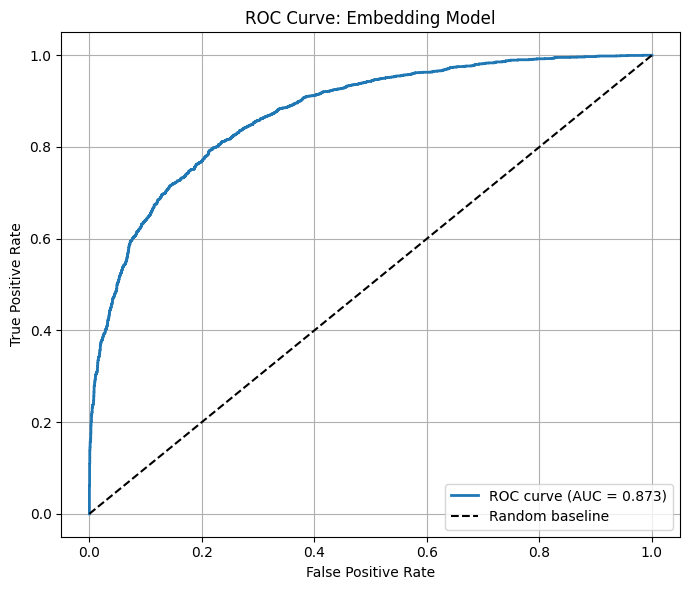

------------------------------
✅ ROC curve saved to: /content/drive/MyDrive/Lab_Sarcasm/model_embeddings/roc_curve_embedding_model.png
------------------------------


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

# --------------------------
# Path Configuration
# --------------------------
# 1. Base Data Path
base_path = "/content/drive/MyDrive/Lab_Sarcasm"
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm" # Fallback

# 2. Model/Output Path (The new subfolder)
model_dir = os.path.join(base_path, "model_embeddings")

# Define file paths
# Note: Checks for .keras (new) first, then .h5
model_filename = "sarcasm_embedding_model_new.keras"
if not os.path.exists(os.path.join(model_dir, model_filename)):
    model_filename = "sarcasm_embedding_model_new.h5"

model_path = os.path.join(model_dir, model_filename)

print(f"📂 Base Path: {base_path}")
print(f"📂 Model Path: {model_path}")

# --------------------------
# Load Resources
# --------------------------
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model not found at {model_path}")

print("Loading model...")
model = load_model(model_path)

print("Loading test data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

# --------------------------
# Predict & Compute ROC
# --------------------------
print("Predicting probabilities...")
# (sigmoid outputs probability for class 1)
y_prob = model.predict(X_test, verbose=0).ravel()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"✅ AUC Score = {roc_auc:.4f}")

# --------------------------
# Plot & Save
# --------------------------
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random baseline")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Embedding Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Save plot to the model_embeddings folder
plot_filename = "roc_curve_embedding_model.png"
plot_path = os.path.join(model_dir, plot_filename)

plt.savefig(plot_path)
plt.show()

print("-" * 30)
print(f"✅ ROC curve saved to: {plot_path}")
print("-" * 30)

## Testing

In [ ]:
# test_on_custom_20.py
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

model = load_model("/content/drive/MyDrive/Lab_Sarcasm/model_embeddings/sarcasm_embedding_model_new.keras")

with open("tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

max_len = X_test.shape[1]

sentences = [
    # Sarcastic (1)
    "Oh yes, because waking up at 5am is exactly what I wanted.",
    "Amazing, another update that totally broke my phone.",
    "Great job! You only crashed the car a little bit.",
    "Wow, I love when my food delivery arrives two hours late.",
    "Fantastic, now my computer won’t even turn on.",
    "Perfect! It started raining right after I washed my car.",
    "Sure, let’s pretend everything is totally fine.",
    "Oh wonderful, the meeting got extended by an hour.",
    "Yeah, because that was the smartest idea ever.",
    "Lovely, the bus left just as I arrived.",
    # Non-sarcastic (0)
    "I enjoyed spending time with my family today.",
    "The movie was very good, I would recommend it.",
    "I had a terrible headache this morning.",
    "He finally finished his project after months of work.",
    "The weather is nice and sunny this afternoon.",
    "I am really happy with my new phone.",
    "My dog got sick, and I had to take him to the vet.",
    "I’m studying hard because exams are next week.",
    "The concert last night was absolutely amazing.",
    "I don’t like this restaurant, the food wasn’t fresh."
]

y_true = np.array([1]*10 + [0]*10)

# Preprocess
seqs = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(seqs, maxlen=max_len, padding="post")

# Predict
probs = model.predict(X_new, verbose=0).ravel()
y_pred = (probs >= 0.5).astype(int)

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"\n🎯 Accuracy on 20 custom sentences: {accuracy*100:.2f}%\n")

# Display results
for i, (txt, t, p, pb) in enumerate(zip(sentences, y_true, y_pred, probs)):
    print(f"{i+1:02d}. True={t} | Pred={p} | Prob={pb:.3f}")
    print(f"    {txt}")
    print("-" * 80)



🎯 Accuracy on 20 custom sentences: 50.00%

01. True=1 | Pred=1 | Prob=0.644
    Oh yes, because waking up at 5am is exactly what I wanted.
--------------------------------------------------------------------------------
02. True=1 | Pred=0 | Prob=0.379
    Amazing, another update that totally broke my phone.
--------------------------------------------------------------------------------
03. True=1 | Pred=1 | Prob=0.914
    Great job! You only crashed the car a little bit.
--------------------------------------------------------------------------------
04. True=1 | Pred=1 | Prob=0.720
    Wow, I love when my food delivery arrives two hours late.
--------------------------------------------------------------------------------
05. True=1 | Pred=1 | Prob=0.681
    Fantastic, now my computer won’t even turn on.
--------------------------------------------------------------------------------
06. True=1 | Pred=1 | Prob=0.582
    Perfect! It started raining right after I washed my car.
-----

2 baseline (these two) the one without embedding and one with embedding
and then we will train LSTM avancé to try to get to 0.8 accuracy

# Technique 1: Deep Bidirectional LSTM

## 1. Training Code (Bi-LSTM)

In [ ]:
"""
Technique 1: Deep Bidirectional LSTM Training Script.
Loads data from Drive, trains a 2-layer Bi-LSTM, and saves to 'model_bilstm' folder.
"""

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --------------------------
# Path Configuration
# --------------------------

# 1. Detect Base Path (Target: /content/drive/MyDrive/Lab_Sarcasm)
base_path = "/content/drive/MyDrive/Lab_Sarcasm"

# Fallback check
if not os.path.exists(base_path):
    print(f"⚠️ Warning: '{base_path}' not found. Checking for 'Lab Sarcasm'...")
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

if not os.path.exists(base_path):
    raise FileNotFoundError("❌ Critical Error: Could not find Lab_Sarcasm folder in Drive.")

print(f"📂 INPUT Directory (Data): {base_path}")

# 2. Setup Output Folder (Target: /content/drive/MyDrive/Lab_Sarcasm/model_bilstm)
output_dir = os.path.join(base_path, "model_bilstm")
os.makedirs(output_dir, exist_ok=True)
print(f"📂 OUTPUT Directory (Model): {output_dir}")

# --------------------------
# File Paths
# --------------------------
# Inputs
TOKENIZER_PATH = os.path.join(base_path, "tokenizer.pickle")
X_TRAIN_PATH   = os.path.join(base_path, "X_train.npy")
Y_TRAIN_PATH   = os.path.join(base_path, "y_train.npy")

# Outputs
OUT_MODEL       = os.path.join(output_dir, "sarcasm_bilstm_model.keras")
CHECKPOINT_PATH = os.path.join(output_dir, "best_bilstm_model.keras")

# --------------------------
# Load Data
# --------------------------
print("Loading data...")
if not os.path.exists(X_TRAIN_PATH):
    raise FileNotFoundError(f"Missing X_train.npy at {X_TRAIN_PATH}")

X_train = np.load(X_TRAIN_PATH)
y_train = np.load(Y_TRAIN_PATH)

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

# --------------------------
# Model Configuration
# --------------------------
VOCAB_SIZE = min(10000, len(tokenizer.word_index) + 1)
MAX_LEN = X_train.shape[1]
EMBEDDING_DIM = 100

print(f"Vocab Size: {VOCAB_SIZE}")
print(f"Max Length: {MAX_LEN}")

# --------------------------
# Build Deep Bi-LSTM Model
# --------------------------
print("Building Deep Bi-LSTM...")

model = Sequential([
    # Embedding Layer (Removed input_length to avoid warnings)
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),

    # Layer 1: Returns sequences for the next LSTM layer
    # Process sequence forward and backward
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4))),
    Dropout(0.5),

    # Layer 2: Consumes sequences, produces single vector
    Bidirectional(LSTM(32)),
    Dropout(0.5),

    # Dense Layers
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(1, activation='sigmoid')
])

# Explicitly build to show summary immediately
model.build(input_shape=(None, MAX_LEN))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --------------------------
# Training
# --------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    # Saving full model (.keras) to the new folder
    ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, verbose=1)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

# --------------------------
# Save Final Model
# --------------------------
model.save(OUT_MODEL)
print("-" * 30)
print(f"✅ Final model saved to: {OUT_MODEL}")
print(f"✅ Best checkpoint saved to: {CHECKPOINT_PATH}")
print("-" * 30)

📂 INPUT Directory (Data): /content/drive/MyDrive/Lab_Sarcasm
📂 OUTPUT Directory (Model): /content/drive/MyDrive/Lab_Sarcasm/model_bilstm
Loading data...
Vocab Size: 10000
Max Length: 100
Building Deep Bi-LSTM...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,127,809 (4.30 MB)

 Trainable params: 1,127,809 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/20

Epoch 1: val_loss improved from inf to 0.69510, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_bilstm/best_bilstm_model.keras
301/301 - 14s - 47ms/step - accuracy: 0.5607 - loss: 0.7095 - val_accuracy: 0.5531 - val_loss: 0.6951
Epoch 2/20

Epoch 2: val_loss improved from 0.69510 to 0.49541, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_bilstm/best_bilstm_model.keras
301/301 - 6s - 19ms/step - accuracy: 0.7105 - loss: 0.5793 - val_accuracy: 0.7833 - val_loss: 0.4954
Epoch 3/20

Epoch 3: val_loss did not improve from 0.49541
301/301 - 7s - 23ms/step - accuracy: 0.8405 - loss: 0.4048 - val_accuracy: 0.7960 - val_loss: 0.4975
Epoch 4/20

Epoch 4: val_loss did not improve from 0.49541
301/301 - 6s - 19ms/step - accuracy: 0.8814 - loss: 0.3304 - val_accuracy: 0.7885 - val_loss: 0.5538
Epoch 5/20

Epoch 5: val_loss did not improve from 0.49541
301/301 - 7s - 22ms/step - accuracy: 0.9028 - loss: 0.2881 - val_accuracy: 0.7735 - val_loss: 0.6

## Evaluation

📂 Base Path: /content/drive/MyDrive/Lab_Sarcasm
📂 Model Path: /content/drive/MyDrive/Lab_Sarcasm/model_bilstm/sarcasm_bilstm_model.keras
Loading Bi-LSTM model...
Loading test data...
Generating predictions...

🔥 Test Accuracy: 77.37%

Confusion Matrix:
[[2554  442]
 [ 767 1579]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7690    0.8525    0.8086      2996
           1     0.7813    0.6731    0.7232      2346

    accuracy                         0.7737      5342
   macro avg     0.7752    0.7628    0.7659      5342
weighted avg     0.7744    0.7737    0.7711      5342

✅ CSV Report saved to: /content/drive/MyDrive/Lab_Sarcasm/model_bilstm/bilstm_evaluation_report.csv


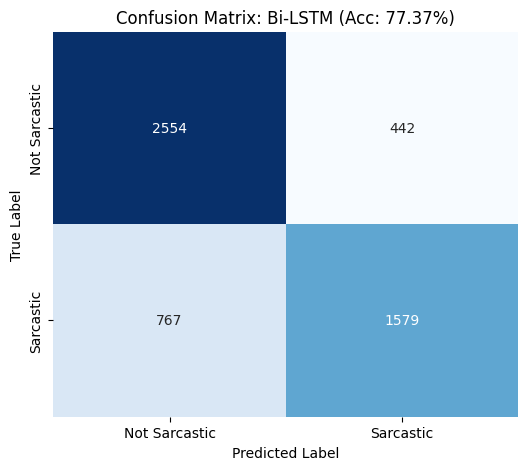

✅ Confusion Matrix Image saved to: /content/drive/MyDrive/Lab_Sarcasm/model_bilstm/bilstm_confusion_matrix.png
------------------------------


In [ ]:
"""
Evaluation Script for Deep Bi-LSTM Model.
Loads the model from 'model_bilstm', computes the Confusion Matrix,
and saves the results (CSV + Plot) back to that folder.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --------------------------
# Path Configuration
# --------------------------
# 1. Base Data Path
base_path = "/content/drive/MyDrive/Lab_Sarcasm"
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

# 2. Model/Output Path (Specific to Bi-LSTM)
model_dir = os.path.join(base_path, "model_bilstm")

# 3. Model File (Checks for .keras first)
model_filename = "sarcasm_bilstm_model.keras"
if not os.path.exists(os.path.join(model_dir, model_filename)):
    model_filename = "sarcasm_bilstm_model.h5"

model_path = os.path.join(model_dir, model_filename)

print(f"📂 Base Path: {base_path}")
print(f"📂 Model Path: {model_path}")

# --------------------------
# Load Resources
# --------------------------
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model not found at {model_path}")

print("Loading Bi-LSTM model...")
model = load_model(model_path)

print("Loading test data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

# --------------------------
# Predict
# --------------------------
print("Generating predictions...")
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# --------------------------
# Metrics: Confusion Matrix
# --------------------------
# 1. Calculate
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*30)
print(f"🔥 Test Accuracy: {acc*100:.2f}%")
print("="*30)

print("\nConfusion Matrix:")
print(cm)
# Format: [[TN, FP], [FN, TP]]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# --------------------------
# Save CSV Report
# --------------------------
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.loc['confusion_matrix_TN'] = [cm[0,0], 0, 0, 0]
df_report.loc['confusion_matrix_FP'] = [cm[0,1], 0, 0, 0]
df_report.loc['confusion_matrix_FN'] = [cm[1,0], 0, 0, 0]
df_report.loc['confusion_matrix_TP'] = [cm[1,1], 0, 0, 0]

csv_filename = "bilstm_evaluation_report.csv"
csv_path = os.path.join(model_dir, csv_filename)
df_report.to_csv(csv_path)
print(f"✅ CSV Report saved to: {csv_path}")

# --------------------------
# Plot & Save Confusion Matrix
# --------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: Bi-LSTM (Acc: {acc:.2%})')

plot_filename = "bilstm_confusion_matrix.png"
plot_path = os.path.join(model_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

print(f"✅ Confusion Matrix Image saved to: {plot_path}")
print("-" * 30)

📂 Base Path: /content/drive/MyDrive/Lab_Sarcasm

Loading Test Data...
✅ Loaded 5342 test samples.

--- Starting Evaluation ---
Testing: No Embedding (Baseline)...
   -> AUC: 0.5713 | Acc: 0.5681
Testing: Simple Embedding...
   -> AUC: 0.8734 | Acc: 0.7887
Testing: Deep Bi-LSTM...
   -> AUC: 0.8531 | Acc: 0.7737


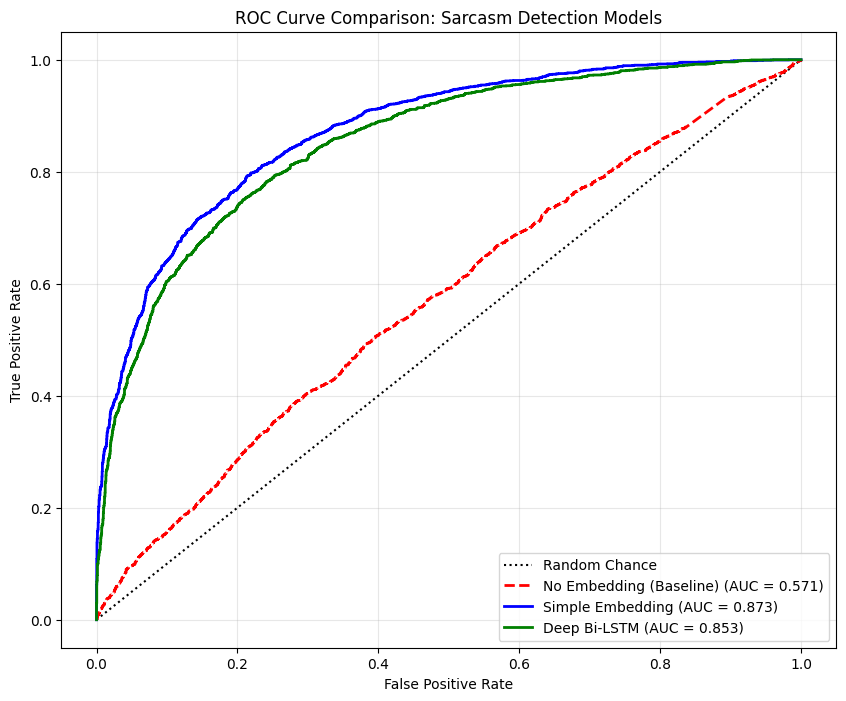


✅ Comparison plot saved to: /content/drive/MyDrive/Lab_Sarcasm/model_comparison_roc.png
✅ Comparison CSV saved to: /content/drive/MyDrive/Lab_Sarcasm/model_comparison_results.csv

Summary Table:
                     Model  Accuracy       AUC
0  No Embedding (Baseline)  0.568139  0.571259
1         Simple Embedding  0.788656  0.873363
2             Deep Bi-LSTM  0.773680  0.853143


In [ ]:
"""
Model Comparison Script
-----------------------
Loads three models from their specific subfolders:
1. No-Embedding Baseline (Model_no_embeddings folder)
2. Embedding Model (model_embeddings folder)
3. Bi-LSTM Model (model_bilstm folder)

Outputs:
- A combined ROC Curve plot.
- A CSV comparing Accuracy and AUC scores.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, accuracy_score

# --------------------------
# Path Configuration
# --------------------------
base_path = "/content/drive/MyDrive/Lab_Sarcasm"

# Fallback for folder name
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

if not os.path.exists(base_path):
    raise FileNotFoundError("❌ Critical Error: Could not find Lab_Sarcasm folder.")

print(f"📂 Base Path: {base_path}")

# --------------------------
# Load Test Data
# --------------------------
print("\nLoading Test Data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))
print(f"✅ Loaded {len(y_test)} test samples.")

# --------------------------
# Model Definitions
# --------------------------
# Define models to compare: (Name, Path, Color, LineStyle)
models_config = [
    {
        "name": "No Embedding (Baseline)",
        # UPDATED PATH: specific subfolder
        "path": os.path.join(base_path, "Model_no_embeddings", "sarcasm_no_embedding_model.h5"),
        # Fallback to root just in case
        "fallback": os.path.join(base_path, "sarcasm_no_embedding_model.h5"),
        "color": "red",
        "style": "--"
    },
    {
        "name": "Simple Embedding",
        # Check for .keras first, fallback to .h5
        "path": os.path.join(base_path, "model_embeddings", "sarcasm_embedding_model_new.keras"),
        "fallback": os.path.join(base_path, "model_embeddings", "sarcasm_embedding_model_new.h5"),
        "color": "blue",
        "style": "-"
    },
    {
        "name": "Deep Bi-LSTM",
        "path": os.path.join(base_path, "model_bilstm", "sarcasm_bilstm_model.keras"),
        "fallback": os.path.join(base_path, "model_bilstm", "sarcasm_bilstm_model.h5"),
        "color": "green",
        "style": "-"
    }
]

# --------------------------
# Evaluation Loop
# --------------------------
results = []

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], "k:", label="Random Chance") # Diagonal line

print("\n--- Starting Evaluation ---")

for config in models_config:
    path = config["path"]
    name = config["name"]

    # Handle Fallback (if main path doesn't exist, check fallback)
    if not os.path.exists(path) and "fallback" in config:
        if os.path.exists(config["fallback"]):
            path = config["fallback"]

    # Check existence
    if not os.path.exists(path):
        print(f"⚠️ Skipping {name}: File not found at {path}")
        continue

    print(f"Testing: {name}...")

    try:
        # Load Model
        model = load_model(path)

        # Predict
        y_prob = model.predict(X_test, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

        # Calculate Metrics
        acc = accuracy_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Store results
        results.append({
            "Model": name,
            "Accuracy": acc,
            "AUC": roc_auc
        })

        # Plot Curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})",
                 color=config["color"], linestyle=config["style"], linewidth=2)

        print(f"   -> AUC: {roc_auc:.4f} | Acc: {acc:.4f}")

    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")

# --------------------------
# Finalize Plot
# --------------------------
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Sarcasm Detection Models")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save Plot
plot_path = os.path.join(base_path, "model_comparison_roc.png")
plt.savefig(plot_path)
plt.show()
print(f"\n✅ Comparison plot saved to: {plot_path}")

# --------------------------
# Save CSV Report
# --------------------------
if results:
    df_results = pd.DataFrame(results)
    csv_path = os.path.join(base_path, "model_comparison_results.csv")
    df_results.to_csv(csv_path, index=False)
    print(f"✅ Comparison CSV saved to: {csv_path}")
    print("\nSummary Table:")
    print(df_results)
else:
    print("\n❌ No models were successfully evaluated.")

## Testing

In [ ]:
# test_on_custom_20.py
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

model = load_model("/content/drive/MyDrive/Lab_Sarcasm/model_bilstm/sarcasm_bilstm_model.keras")

with open("tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

max_len = X_test.shape[1]

sentences = [
    # Sarcastic (1)
    "Oh yes, because waking up at 5am is exactly what I wanted.",
    "Amazing, another update that totally broke my phone.",
    "Great job! You only crashed the car a little bit.",
    "Wow, I love when my food delivery arrives two hours late.",
    "Fantastic, now my computer won’t even turn on.",
    "Perfect! It started raining right after I washed my car.",
    "Sure, let’s pretend everything is totally fine.",
    "Oh wonderful, the meeting got extended by an hour.",
    "Yeah, because that was the smartest idea ever.",
    "Lovely, the bus left just as I arrived.",
    # Non-sarcastic (0)
    "I enjoyed spending time with my family today.",
    "The movie was very good, I would recommend it.",
    "I had a terrible headache this morning.",
    "He finally finished his project after months of work.",
    "The weather is nice and sunny this afternoon.",
    "I am really happy with my new phone.",
    "My dog got sick, and I had to take him to the vet.",
    "I’m studying hard because exams are next week.",
    "The concert last night was absolutely amazing.",
    "I don’t like this restaurant, the food wasn’t fresh."
]

y_true = np.array([1]*10 + [0]*10)

# Preprocess
seqs = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(seqs, maxlen=max_len, padding="post")

# Predict
probs = model.predict(X_new, verbose=0).ravel()
y_pred = (probs >= 0.5).astype(int)

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"\n🎯 Accuracy on 20 custom sentences: {accuracy*100:.2f}%\n")

# Display results
for i, (txt, t, p, pb) in enumerate(zip(sentences, y_true, y_pred, probs)):
    print(f"{i+1:02d}. True={t} | Pred={p} | Prob={pb:.3f}")
    print(f"    {txt}")
    print("-" * 80)



🎯 Accuracy on 20 custom sentences: 50.00%

01. True=1 | Pred=1 | Prob=0.718
    Oh yes, because waking up at 5am is exactly what I wanted.
--------------------------------------------------------------------------------
02. True=1 | Pred=1 | Prob=0.542
    Amazing, another update that totally broke my phone.
--------------------------------------------------------------------------------
03. True=1 | Pred=1 | Prob=0.834
    Great job! You only crashed the car a little bit.
--------------------------------------------------------------------------------
04. True=1 | Pred=0 | Prob=0.420
    Wow, I love when my food delivery arrives two hours late.
--------------------------------------------------------------------------------
05. True=1 | Pred=1 | Prob=0.716
    Fantastic, now my computer won’t even turn on.
--------------------------------------------------------------------------------
06. True=1 | Pred=0 | Prob=0.337
    Perfect! It started raining right after I washed my car.
-----

# Technique 2: C-LSTM (CNN + LSTM Hybrid)

## Training Code (C-LSTM)

In [ ]:
"""
Technique 2: C-LSTM (CNN + LSTM) Training Script.
Combines Convolutional layers (for feature extraction) with LSTM (for sequence processing).
Saves results to the 'model_clstm' folder.
"""

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --------------------------
# Path Configuration
# --------------------------

# 1. Detect Base Path (Target: /content/drive/MyDrive/Lab_Sarcasm)
base_path = "/content/drive/MyDrive/Lab_Sarcasm"

# Fallback check
if not os.path.exists(base_path):
    print(f"⚠️ Warning: '{base_path}' not found. Checking for 'Lab Sarcasm'...")
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

if not os.path.exists(base_path):
    raise FileNotFoundError("❌ Critical Error: Could not find Lab_Sarcasm folder in Drive.")

print(f"📂 INPUT Directory (Data): {base_path}")

# 2. Setup Output Folder (Target: /content/drive/MyDrive/Lab_Sarcasm/model_clstm)
output_dir = os.path.join(base_path, "model_clstm")
os.makedirs(output_dir, exist_ok=True)
print(f"📂 OUTPUT Directory (Model): {output_dir}")

# --------------------------
# File Paths
# --------------------------
# Inputs
TOKENIZER_PATH = os.path.join(base_path, "tokenizer.pickle")
X_TRAIN_PATH   = os.path.join(base_path, "X_train.npy")
Y_TRAIN_PATH   = os.path.join(base_path, "y_train.npy")

# Outputs
OUT_MODEL       = os.path.join(output_dir, "sarcasm_clstm_model.keras")
CHECKPOINT_PATH = os.path.join(output_dir, "best_clstm_model.keras")

# --------------------------
# Load Data
# --------------------------
print("Loading data...")
if not os.path.exists(X_TRAIN_PATH):
    raise FileNotFoundError(f"Missing X_train.npy at {X_TRAIN_PATH}")

X_train = np.load(X_TRAIN_PATH)
y_train = np.load(Y_TRAIN_PATH)

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

# --------------------------
# Model Configuration
# --------------------------
VOCAB_SIZE = min(10000, len(tokenizer.word_index) + 1)
MAX_LEN = X_train.shape[1]
EMBEDDING_DIM = 100

print(f"Vocab Size: {VOCAB_SIZE}")
print(f"Max Length: {MAX_LEN}")

# --------------------------
# Build C-LSTM Model
# --------------------------
print("Building C-LSTM Model...")

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),

    # CNN Layer: Extracts local features (3-grams/5-grams)
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM Layer: Analyzes the sequence of features extracted by CNN
    # Note: recurrent_dropout is useful but might slow down training on GPUs
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),

    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Explicitly build to show summary immediately
model.build(input_shape=(None, MAX_LEN))

model.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --------------------------
# Training
# --------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, verbose=1)
]

print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

# --------------------------
# Save Final Model
# --------------------------
model.save(OUT_MODEL)
print("-" * 30)
print(f"✅ Final model saved to: {OUT_MODEL}")
print(f"✅ Best checkpoint saved to: {CHECKPOINT_PATH}")
print("-" * 30)

📂 INPUT Directory (Data): /content/drive/MyDrive/Lab_Sarcasm
📂 OUTPUT Directory (Model): /content/drive/MyDrive/Lab_Sarcasm/model_clstm
Loading data...
Vocab Size: 10000
Max Length: 100
Building C-LSTM Model...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,115,649 (4.26 MB)

 Trainable params: 1,115,649 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/20

Epoch 1: val_loss improved from inf to 0.68780, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_clstm/best_clstm_model.keras
301/301 - 66s - 219ms/step - accuracy: 0.5604 - loss: 0.6869 - val_accuracy: 0.5517 - val_loss: 0.6878
Epoch 2/20

Epoch 2: val_loss did not improve from 0.68780
301/301 - 58s - 192ms/step - accuracy: 0.5620 - loss: 0.6865 - val_accuracy: 0.5517 - val_loss: 0.6878
Epoch 3/20

Epoch 3: val_loss did not improve from 0.68780
301/301 - 54s - 178ms/step - accuracy: 0.5620 - loss: 0.6864 - val_accuracy: 0.5517 - val_loss: 0.6878
Epoch 4/20

Epoch 4: val_loss did not improve from 0.68780
301/301 - 55s - 182ms/step - accuracy: 0.5621 - loss: 0.6863 - val_accuracy: 0.5517 - val_loss: 0.6878
Epoch 5/20

Epoch 5: val_loss improved from 0.68780 to 0.68779, saving model to /content/drive/MyDrive/Lab_Sarcasm/model_clstm/best_clstm_model.keras
301/301 - 73s - 242ms/step - accuracy: 0.5621 - loss: 0.6860 - val_accuracy: 0.5517 - val_loss

📂 Base Path: /content/drive/MyDrive/Lab_Sarcasm
📂 Model Path: /content/drive/MyDrive/Lab_Sarcasm/model_clstm/sarcasm_clstm_model.keras
Loading C-LSTM model...
Loading test data...
Generating predictions...

🔥 Test Accuracy: 75.59%

Confusion Matrix:
[[2381  615]
 [ 689 1657]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7756    0.7947    0.7850      2996
           1     0.7293    0.7063    0.7176      2346

    accuracy                         0.7559      5342
   macro avg     0.7524    0.7505    0.7513      5342
weighted avg     0.7553    0.7559    0.7554      5342

✅ CSV Report saved to: /content/drive/MyDrive/Lab_Sarcasm/model_clstm/clstm_evaluation_report.csv


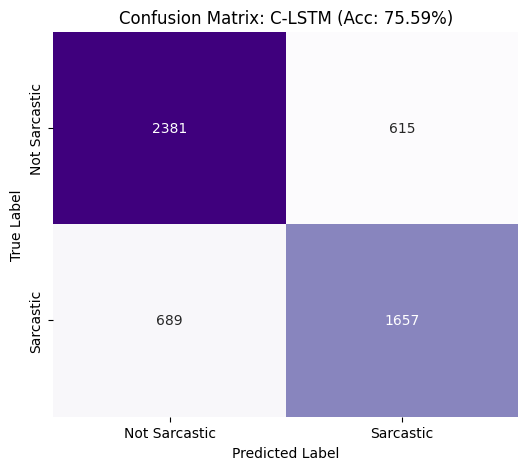

✅ Confusion Matrix Image saved to: /content/drive/MyDrive/Lab_Sarcasm/model_clstm/clstm_confusion_matrix.png
------------------------------


In [ ]:
"""
Evaluation Script for C-LSTM Model.
Loads the model from 'model_clstm', computes the Confusion Matrix,
and saves the results (CSV + Plot) back to that folder.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --------------------------
# Path Configuration
# --------------------------
# 1. Base Data Path
base_path = "/content/drive/MyDrive/Lab_Sarcasm"
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

# 2. Model/Output Path (Specific to C-LSTM)
model_dir = os.path.join(base_path, "model_clstm")

# 3. Model File (Checks for .keras first)
model_filename = "sarcasm_clstm_model.keras"
if not os.path.exists(os.path.join(model_dir, model_filename)):
    model_filename = "sarcasm_clstm_model.h5"

model_path = os.path.join(model_dir, model_filename)

print(f"📂 Base Path: {base_path}")
print(f"📂 Model Path: {model_path}")

# --------------------------
# Load Resources
# --------------------------
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model not found at {model_path}")

print("Loading C-LSTM model...")
model = load_model(model_path)

print("Loading test data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

# --------------------------
# Predict
# --------------------------
print("Generating predictions...")
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# --------------------------
# Metrics: Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("\n" + "="*30)
print(f"🔥 Test Accuracy: {acc*100:.2f}%")
print("="*30)

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# --------------------------
# Save CSV Report
# --------------------------
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
# Add CM stats manually
df_report.loc['confusion_matrix_TN'] = [cm[0,0], 0, 0, 0]
df_report.loc['confusion_matrix_FP'] = [cm[0,1], 0, 0, 0]
df_report.loc['confusion_matrix_FN'] = [cm[1,0], 0, 0, 0]
df_report.loc['confusion_matrix_TP'] = [cm[1,1], 0, 0, 0]

csv_filename = "clstm_evaluation_report.csv"
csv_path = os.path.join(model_dir, csv_filename)
df_report.to_csv(csv_path)
print(f"✅ CSV Report saved to: {csv_path}")

# --------------------------
# Plot & Save Confusion Matrix
# --------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: C-LSTM (Acc: {acc:.2%})')

plot_filename = "clstm_confusion_matrix.png"
plot_path = os.path.join(model_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

print(f"✅ Confusion Matrix Image saved to: {plot_path}")
print("-" * 30)

📂 Base Path: /content/drive/MyDrive/Lab_Sarcasm

Loading Test Data...
✅ Loaded 5342 test samples.

--- Starting Evaluation ---
Testing: No Embedding...
   -> AUC: 0.5713 | Acc: 0.5681
Testing: Simple Embedding...
   -> AUC: 0.8734 | Acc: 0.7887
Testing: Deep Bi-LSTM...
   -> AUC: 0.8531 | Acc: 0.7737
Testing: C-LSTM (CNN+LSTM)...
   -> AUC: 0.8288 | Acc: 0.7559


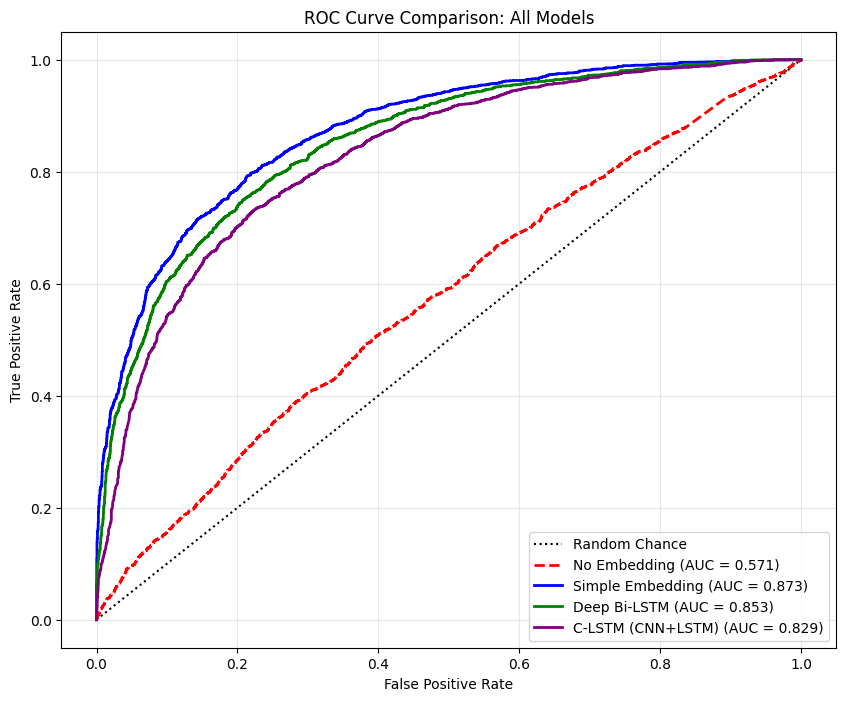


✅ Comparison plot updated/overwritten: /content/drive/MyDrive/Lab_Sarcasm/model_comparison_roc.png
✅ Comparison CSV updated/overwritten: /content/drive/MyDrive/Lab_Sarcasm/model_comparison_results.csv

Summary Table:
               Model  Accuracy       AUC
0       No Embedding  0.568139  0.571259
1   Simple Embedding  0.788656  0.873363
2       Deep Bi-LSTM  0.773680  0.853143
3  C-LSTM (CNN+LSTM)  0.755897  0.828761


In [ ]:
"""
Model Comparison Script (Updated)
---------------------------------
Loads FOUR models from their specific subfolders:
1. No-Embedding Baseline (Model_no_embeddings folder)
2. Simple Embedding (model_embeddings folder)
3. Deep Bi-LSTM (model_bilstm folder)
4. C-LSTM (model_clstm folder)

Outputs:
- A combined ROC Curve plot (Overwrites 'model_comparison_roc.png')
- A CSV comparing Accuracy and AUC scores (Overwrites 'model_comparison_results.csv')
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc, accuracy_score

# --------------------------
# Path Configuration
# --------------------------
base_path = "/content/drive/MyDrive/Lab_Sarcasm"

# Fallback for folder name
if not os.path.exists(base_path):
    base_path = "/content/drive/MyDrive/Lab Sarcasm"

if not os.path.exists(base_path):
    raise FileNotFoundError("❌ Critical Error: Could not find Lab_Sarcasm folder.")

print(f"📂 Base Path: {base_path}")

# --------------------------
# Load Test Data
# --------------------------
print("\nLoading Test Data...")
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))
print(f"✅ Loaded {len(y_test)} test samples.")

# --------------------------
# Model Definitions
# --------------------------
models_config = [
    {
        "name": "No Embedding",
        "path": os.path.join(base_path, "Model_no_embeddings", "sarcasm_no_embedding_model.h5"),
        "fallback": os.path.join(base_path, "sarcasm_no_embedding_model.h5"),
        "color": "red",
        "style": "--"
    },
    {
        "name": "Simple Embedding",
        "path": os.path.join(base_path, "model_embeddings", "sarcasm_embedding_model_new.keras"),
        "fallback": os.path.join(base_path, "model_embeddings", "sarcasm_embedding_model_new.h5"),
        "color": "blue",
        "style": "-"
    },
    {
        "name": "Deep Bi-LSTM",
        "path": os.path.join(base_path, "model_bilstm", "sarcasm_bilstm_model.keras"),
        "fallback": os.path.join(base_path, "model_bilstm", "sarcasm_bilstm_model.h5"),
        "color": "green",
        "style": "-"
    },
    {
        "name": "C-LSTM (CNN+LSTM)",
        "path": os.path.join(base_path, "model_clstm", "sarcasm_clstm_model.keras"),
        "fallback": os.path.join(base_path, "model_clstm", "sarcasm_clstm_model.h5"),
        "color": "purple",
        "style": "-"
    }
]

# --------------------------
# Evaluation Loop
# --------------------------
results = []

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], "k:", label="Random Chance") # Diagonal line

print("\n--- Starting Evaluation ---")

for config in models_config:
    path = config["path"]
    name = config["name"]

    # Handle Fallback
    if not os.path.exists(path) and "fallback" in config:
        if os.path.exists(config["fallback"]):
            path = config["fallback"]

    if not os.path.exists(path):
        print(f"⚠️ Skipping {name}: File not found at {path}")
        continue

    print(f"Testing: {name}...")

    try:
        model = load_model(path)
        y_prob = model.predict(X_test, verbose=0).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "AUC": roc_auc
        })

        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})",
                 color=config["color"], linestyle=config["style"], linewidth=2)

        print(f"   -> AUC: {roc_auc:.4f} | Acc: {acc:.4f}")

    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")

# --------------------------
# Finalize Plot
# --------------------------
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: All Models")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Note: Overwriting the previous file names
plot_path = os.path.join(base_path, "model_comparison_roc.png")
plt.savefig(plot_path)
plt.show()
print(f"\n✅ Comparison plot updated/overwritten: {plot_path}")

# --------------------------
# Save CSV Report
# --------------------------
if results:
    df_results = pd.DataFrame(results)
    # Note: Overwriting the previous file names
    csv_path = os.path.join(base_path, "model_comparison_results.csv")
    df_results.to_csv(csv_path, index=False)
    print(f"✅ Comparison CSV updated/overwritten: {csv_path}")
    print("\nSummary Table:")
    print(df_results)
else:
    print("\n❌ No models were successfully evaluated.")

In [ ]:
# test_on_custom_20.py
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

model = load_model("/content/drive/MyDrive/Lab_Sarcasm/model_clstm/sarcasm_clstm_model.keras")

with open("tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

max_len = X_test.shape[1]

sentences = [
    # Sarcastic (1)
    "Oh yes, because waking up at 5am is exactly what I wanted.",
    "Amazing, another update that totally broke my phone.",
    "Great job! You only crashed the car a little bit.",
    "Wow, I love when my food delivery arrives two hours late.",
    "Fantastic, now my computer won’t even turn on.",
    "Perfect! It started raining right after I washed my car.",
    "Sure, let’s pretend everything is totally fine.",
    "Oh wonderful, the meeting got extended by an hour.",
    "Yeah, because that was the smartest idea ever.",
    "Lovely, the bus left just as I arrived.",
    # Non-sarcastic (0)
    "I enjoyed spending time with my family today.",
    "The movie was very good, I would recommend it.",
    "I had a terrible headache this morning.",
    "He finally finished his project after months of work.",
    "The weather is nice and sunny this afternoon.",
    "I am really happy with my new phone.",
    "My dog got sick, and I had to take him to the vet.",
    "I’m studying hard because exams are next week.",
    "The concert last night was absolutely amazing.",
    "I don’t like this restaurant, the food wasn’t fresh."
]

y_true = np.array([1]*10 + [0]*10)

# Preprocess
seqs = tokenizer.texts_to_sequences(sentences)
X_new = pad_sequences(seqs, maxlen=max_len, padding="post")

# Predict
probs = model.predict(X_new, verbose=0).ravel()
y_pred = (probs >= 0.5).astype(int)

# Accuracy
accuracy = (y_pred == y_true).mean()
print(f"\n🎯 Accuracy on 20 custom sentences: {accuracy*100:.2f}%\n")

# Display results
for i, (txt, t, p, pb) in enumerate(zip(sentences, y_true, y_pred, probs)):
    print(f"{i+1:02d}. True={t} | Pred={p} | Prob={pb:.3f}")
    print(f"    {txt}")
    print("-" * 80)



🎯 Accuracy on 20 custom sentences: 50.00%

01. True=1 | Pred=1 | Prob=0.771
    Oh yes, because waking up at 5am is exactly what I wanted.
--------------------------------------------------------------------------------
02. True=1 | Pred=0 | Prob=0.149
    Amazing, another update that totally broke my phone.
--------------------------------------------------------------------------------
03. True=1 | Pred=1 | Prob=0.771
    Great job! You only crashed the car a little bit.
--------------------------------------------------------------------------------
04. True=1 | Pred=1 | Prob=0.771
    Wow, I love when my food delivery arrives two hours late.
--------------------------------------------------------------------------------
05. True=1 | Pred=1 | Prob=0.771
    Fantastic, now my computer won’t even turn on.
--------------------------------------------------------------------------------
06. True=1 | Pred=1 | Prob=0.771
    Perfect! It started raining right after I washed my car.
-----